In [1]:
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from gensim.utils import simple_preprocess
from tqdm import tqdm

In [2]:
dataset='vizwiz'
karpathy_json_path='data/dataset_coco.json'
image_folder='data/coco_imgs/'
captions_per_image=5
min_word_freq=5
output_folder='data/coco_captions/'
max_len=50

In [69]:
viz_json_path = 'data/viz_annotations/train.json'
with open(viz_json_path, 'r') as j:
    train = json.load(j)

viz_json_path = 'data/viz_annotations/val.json'
with open(viz_json_path, 'r') as j:
    val = json.load(j)

In [70]:
train.keys(), val.keys()

(dict_keys(['info', 'images', 'annotations']),
 dict_keys(['info', 'images', 'annotations']))

In [25]:
train['annotations'][0]

{'is_precanned': False,
 'image_id': 0,
 'is_rejected': False,
 'caption': 'ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.',
 'id': 0,
 'text_detected': True}

In [36]:
def process_annotations(ann):
    ann = pd.DataFrame(ann)
    print(ann.text_detected.value_counts())
    PIC_QUALITY_ISSUE = 'Quality issues are too severe to recognize visual content.'
    ann = ann[ann.caption != PIC_QUALITY_ISSUE]
    ann = ann[~ann.is_rejected]
    ann_t = ann.groupby(['image_id', 'text_detected']).size().reset_index()
    ann_t = ann_t.rename(columns={0: 'count_num'})
    no_dup = ann_t[~ann_t.image_id.duplicated(keep=False)]
    no_dup_true = no_dup[no_dup.text_detected]
    ann.loc[~ann.image_id.isin(no_dup_true.image_id), 'text_detected'] = False
    return ann

In [37]:
train_ann = process_annotations(train['annotations'])
val_ann = process_annotations(val['annotations'])

True     71394
False    45761
Name: text_detected, dtype: int64
True     24328
False    14422
Name: text_detected, dtype: int64


In [39]:
train_ann.shape, val_ann.shape

((100575, 6), (33145, 6))

In [43]:
train_ann['split'] = 'train'
val_ann['split'] = 'val'

In [45]:
data = train_ann.append(val_ann, ignore_index=True)

In [46]:
data.split.value_counts()

train    100575
val       33145
Name: split, dtype: int64

In [74]:
IMGS = pd.DataFrame(IMGS)

,file_name,vizwiz_url,id,text_detected
0,VizWiz_train_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualiz...,0,True
1,VizWiz_train_00000001.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualiz...,1,True
2,VizWiz_train_00000002.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualiz...,2,True
3,VizWiz_train_00000003.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualiz...,3,True
4,VizWiz_train_00000004.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualiz...,4,True
...,...,...,...,...
31176,VizWiz_val_00007745.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualiz...,31176,True
31177,VizWiz_val_00007746.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualiz...,31177,True
31178,VizWiz_val_00007747.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualiz...,31178,True
31179,VizWiz_val_00007748.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualiz...,31179,False


In [90]:
len(train['images']), len(val['images'])

(23431, 7750)

In [73]:
IMGS = train['images'] + val['images']

In [81]:
assert (~data['image_id'].isin(pd.DataFrame(IMGS)['id'])).sum() == 0

In [82]:
viz = {
    'images': [],
    'dataset': 'vizwiz'
}

In [86]:
#dict_keys(['filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid'])
data_root = 'data/vizwiz/'
# VIZ_SPLIT = 'val'
filepath = f'vizwiz_imgs/'

c = 0
for d in tqdm(IMGS):
    v = {}
    v['filepath'] = filepath
    v['filename'] = d['file_name']
    v['imgid'] = d['id']
    v['sentids'] = ann[ann.image_id == d['id']]['id'].to_list()
    v['sentences'] = []
    for i, row in data[data.image_id == d['id']].iterrows():
        s = {}
        s['raw'] = row['caption']
        s['tokens'] = simple_preprocess(row['caption'])
        s['imgid'] = d['id']
        s['sentid'] = row['id']
        v['sentences'].append(s)
        v['split'] = row['split']
    viz['images'].append(v)
#     c += 1
#     if c == 10:
#         break

100%|██████████| 31181/31181 [01:05<00:00, 479.51it/s]


In [87]:
v

{'filepath': 'vizwiz_imgs/',
 'filename': 'VizWiz_val_00007749.jpg',
 'imgid': 31180,
 'sentids': [155900, 155901, 155902, 155903, 155904],
 'sentences': [{'raw': 'A  closeup of fiat with a value of 10 on a kitchen counter.',
   'tokens': ['closeup',
    'of',
    'fiat',
    'with',
    'value',
    'of',
    'on',
    'kitchen',
    'counter'],
   'imgid': 31180,
   'sentid': 155900},
  {'raw': 'a single piece of Australian currency sitting on a table.',
   'tokens': ['single',
    'piece',
    'of',
    'australian',
    'currency',
    'sitting',
    'on',
    'table'],
   'imgid': 31180,
   'sentid': 155901},
  {'raw': 'An Australian monetary bill with the value of 10 displayed.',
   'tokens': ['an',
    'australian',
    'monetary',
    'bill',
    'with',
    'the',
    'value',
    'of',
    'displayed'],
   'imgid': 31180,
   'sentid': 155902},
  {'raw': 'An Australian ten dollar bill sitting on a brown surface.',
   'tokens': ['an',
    'australian',
    'ten',
    'dollar',


In [88]:
import json
with open('data/viz.json', 'w', encoding='utf-8') as f:
    json.dump(viz, f, ensure_ascii=False, indent=4)

In [180]:
v

{'filepath': 'viz_train',
 'filename': 'VizWiz_train_00023430.jpg',
 'imgid': 23430,
 'sentids': [117150, 117151, 117152, 117153, 117154],
 'split': 'train',
 'sentences': [{'raw': 'The back of a plastic card such as a credit card that has a lot of written instructions or information on it, and a scratch off area that says Scratch off Gently For Claim Code.',
   'tokens': ['the',
    'back',
    'of',
    'plastic',
    'card',
    'such',
    'as',
    'credit',
    'card',
    'that',
    'has',
    'lot',
    'of',
    'written',
    'instructions',
    'or',
    'information',
    'on',
    'it',
    'and',
    'scratch',
    'off',
    'area',
    'that',
    'says',
    'scratch',
    'off',
    'gently',
    'for',
    'claim',
    'code'],
   'imgid': 23430,
   'sentid': 117150},
  {'raw': 'A card is seen with a scratch strip to reveal a code.',
   'tokens': ['card',
    'is',
    'seen',
    'with',
    'scratch',
    'strip',
    'to',
    'reveal',
    'code'],
   'imgid': 2

In [173]:
viz.keys()

dict_keys(['images', 'dataset'])

In [125]:
no_dup_true = no_dup[no_dup.text_detected].sample(20)['image_id'].to_list()
no_dup_false = no_dup[~no_dup.text_detected].sample(20)['image_id'].to_list()

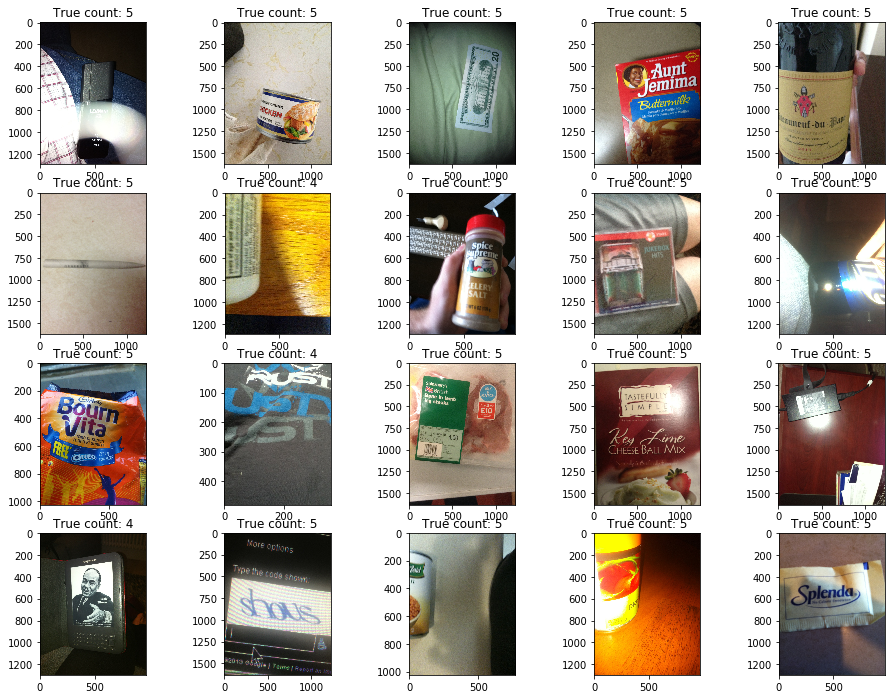

In [126]:
fig, axs = plt.subplots(4, 5, figsize=(16, 12))

r = 0
c = 0
for i in no_dup_true:
    file_path = 'data/vizwiz/viz_train/'
    df = ann_t[(ann_t.image_id == i)]
    is_true = df.loc[df.text_detected, 'count_num'].tolist()[0]
    image_id = df.image_id.tolist()[0]
    filename = imgs[imgs.id == image_id]['file_name'].tolist()[0]
    im_path = file_path + filename
    im = mpimg.imread(im_path)
#     plt.imshow(im)

    axs[r, c].imshow(im)
    axs[r, c].set_title(f'True count: {is_true}')
    if c != 4:
        c +=1
    else:
        c = 0
        r += 1

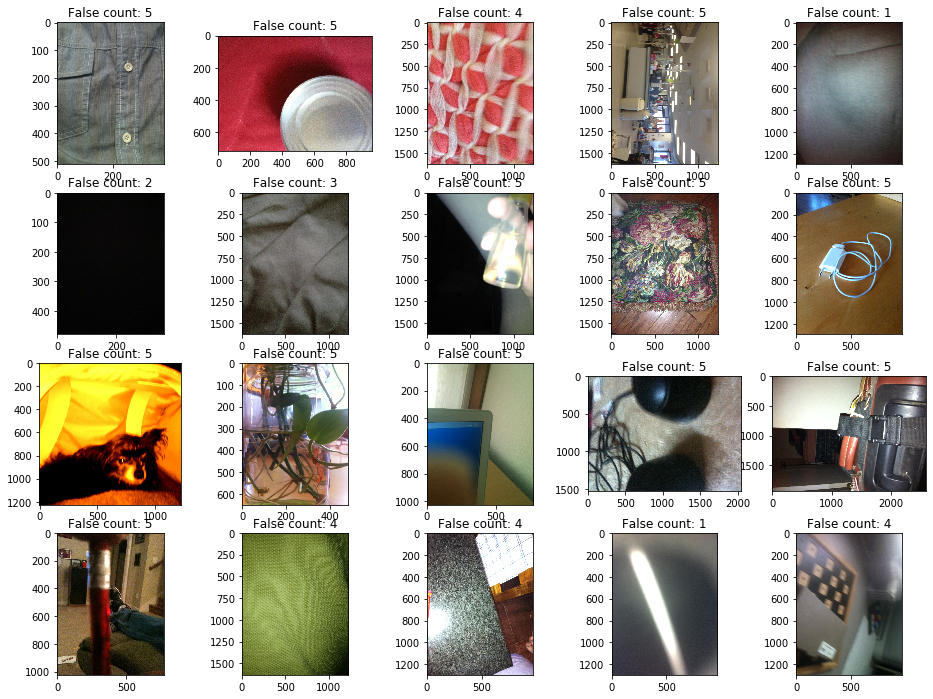

In [128]:
fig, axs = plt.subplots(4, 5, figsize=(16, 12))

r = 0
c = 0
for i in no_dup_false:
    file_path = 'data/vizwiz/viz_train/'
    df = ann_t[(ann_t.image_id == i)]
    is_false = df.loc[~df.text_detected, 'count_num'].tolist()[0]
    image_id = df.image_id.tolist()[0]
    filename = imgs[imgs.id == image_id]['file_name'].tolist()[0]
    im_path = file_path + filename
    im = mpimg.imread(im_path)
#     plt.imshow(im)

    axs[r, c].imshow(im)
    axs[r, c].set_title(f'False count: {is_false}')
    if c != 4:
        c +=1
    else:
        c = 0
        r += 1

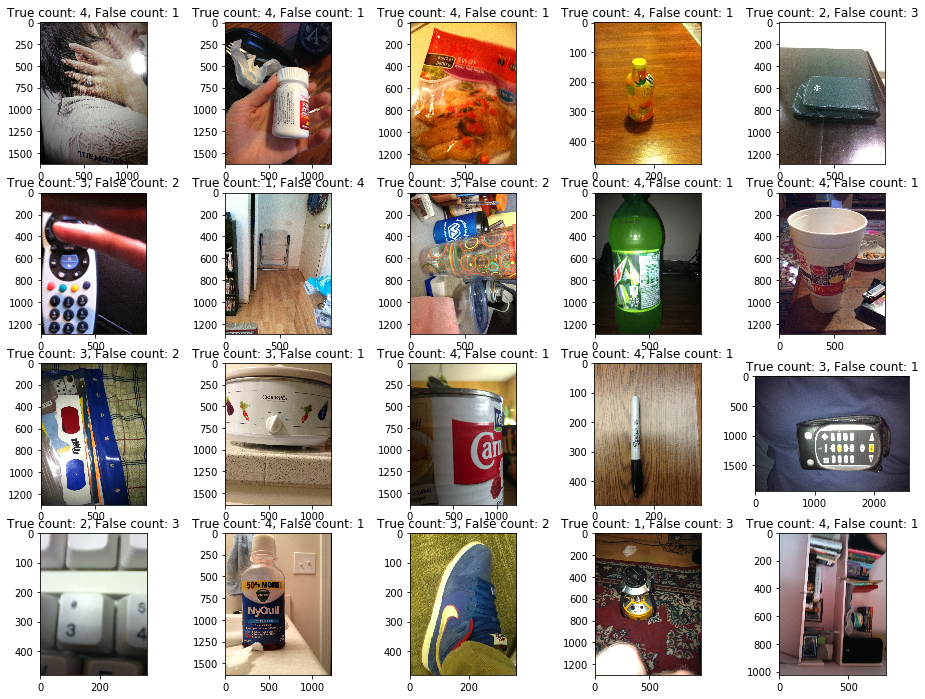

In [117]:
fig, axs = plt.subplots(4, 5, figsize=(16, 12))

r = 0
c = 0
for i in dup_ids:
    file_path = 'data/vizwiz/viz_train/'
    df = ann_t[(ann_t.image_id == i)]
    is_true = df.loc[df.text_detected, 'count_num'].tolist()[0]
    is_false = df.loc[~df.text_detected, 'count_num'].tolist()[0]
    image_id = df.image_id.tolist()[0]
    filename = imgs[imgs.id == image_id]['file_name'].tolist()[0]
    im_path = file_path + filename
    im = mpimg.imread(im_path)
#     plt.imshow(im)

    axs[r, c].imshow(im)
    axs[r, c].set_title(f'True count: {is_true}, False count: {is_false}')
    if c != 4:
        c +=1
    else:
        c = 0
        r += 1

In [115]:
r, c

(0, 5)

In [103]:
is_true, is_false

(4, 1)

In [97]:
is_true

10624    4
Name: count_num, dtype: int64

In [94]:
ann_t

,image_id,text_detected,count_num
0,0,True,4
1,1,True,5
2,2,True,5
3,3,False,1
4,3,True,4
...,...,...,...
27387,23427,False,1
27388,23427,True,2
27389,23428,True,5
27390,23429,True,5


In [80]:
ann_t[ann_t & (ann_t['count_num'] > 2)].sample(10)['image_id'].tolist()

,image_id,text_detected,count_num
16600,14127,True,3
15998,13618,True,5
9016,7639,True,5
17210,14651,False,5
11463,9726,False,4
20739,17702,True,3
12157,10330,False,5
23114,19737,True,5
6826,5758,True,5
8154,6908,True,5


In [67]:
file_path = 'data/vizwiz/viz_train/'

In [65]:
filename = imgs[imgs.id == 3]['file_name'].tolist()[0]

In [68]:
im_path = file_path + filename

In [72]:
im = mpimg.imread(im_path)

plt.imshow(im)

In [105]:
def show_img(im_path):
    im = cv2.imread(im_path)
    im = mpimg.imread(im_path)
    return im

In [19]:
with open(karpathy_json_path, 'r') as j:
    coco = json.load(j)

In [20]:
coco.keys()

dict_keys(['images', 'dataset'])

In [21]:
coco['images'][0].keys()

dict_keys(['filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid'])

In [27]:
coco['images'][1]['sentences'][0]

{'tokens': ['a',
  'woman',
  'wearing',
  'a',
  'net',
  'on',
  'her',
  'head',
  'cutting',
  'a',
  'cake'],
 'raw': 'A woman wearing a net on her head cutting a cake. ',
 'imgid': 1,
 'sentid': 681330}